In [31]:
import numpy as np
import glob
import os
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [5]:
datadir = "/data_local/DataOceano/AVISO/ABACUS"
datafilelist = sorted(glob.glob(os.path.join(datadir, '*nc')))

In [6]:
for datafiles in datafilelist:
    print datafiles

/data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0016_P0773.nc
/data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0018_P0773.nc
/data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0019_P0229.nc


In [24]:
#def readSLA40(datafile)
with netCDF4.Dataset(datafilelist[0]) as nc:
    time = nc.variables['time_40hz'][:]
    lon = nc.variables['longitude_40hz'][:]
    lat = nc.variables['latitude_40hz'][:]
    sla = nc.variables['sea_level_anomaly_alti_40hz'][:]
    timeunits = nc.variables['time_40hz'].units
    #dates = netCDF4.num2date(time, timeunits)

Select data in our region

In [ ]:
goodcoord = np.where((lon>=lonmin) & lon<=ño )

Initialise the map

In [32]:
m = Basemap(projection='merc',llcrnrlat=35.,urcrnrlat=45.,\
            llcrnrlon=-5.,urcrnrlon=10.,lat_ts=20,resolution='i')

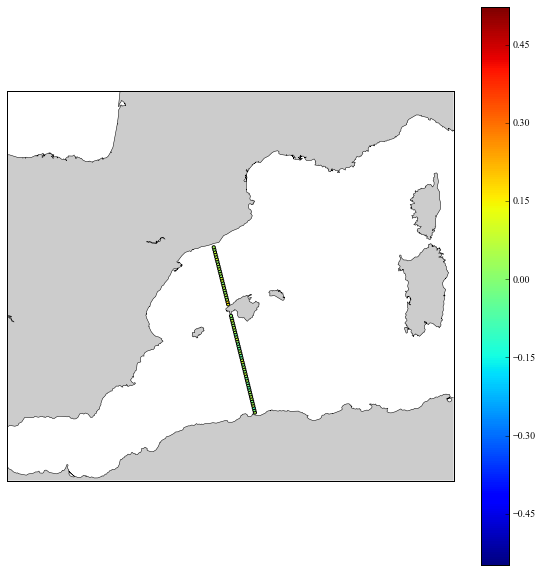

In [44]:
lon2plot, lat2plot = m(lon[:,0], lat[:,0])
lon2plot2, lat2plot2 = m(lon[:,1]+0.2, lat[:,1])
lon2plot3, lat2plot3 = m(lon[:,2]+0.4, lat[:,2])
lon2plot4, lat2plot4 = m(lon[:,3]+0.6, lat[:,3])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes()
m.scatter(lon2plot, lat2plot, 10, sla[:,0], edgecolor=None)
m.drawcoastlines(ax=ax, linewidth=0.5)
m.fillcontinents()
plt.colorbar()
plt.show()

In [23]:
lon[:,12].min()

0.0099039999999999996

In [45]:
time.shape

(2709, 40)